In [84]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten


In [2]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob


In [3]:
base_dir = Path(r'e:\Google Drive\research\projects\utica')
mask_dir = base_dir.joinpath('mask')
train_image_dir = mask_dir.joinpath('u_train_reproject')
trees_mask_dir = mask_dir.joinpath('trees')
building_mask_dir = mask_dir.joinpath('building')
pavement_mask_dir = mask_dir.joinpath('pavement')

In [4]:
I, N, M = 40, 256, 256

In [5]:
os.listdir(mask_dir)

['building', 'desktop.ini', 'pavement', 'trees', 'u_train_reproject']

In [6]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [7]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [8]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[6:-7,6:-6]

In [9]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [10]:
def load_stack_safely(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [11]:
train_images = load_stack_safely((I, N, M), np.float32, train_image_dir, "wgs_train")
tree_masks = load_stack_safely((I, N, M), np.int8, trees_mask_dir, "tree_mask")
building_masks = load_stack_safely((I, N, M), np.int8, building_mask_dir, "building_mask")
pavement_masks = load_stack_safely((I, N, M), np.int8, pavement_mask_dir, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_27.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_31.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_34.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_27.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_31.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_34.tif
skipping e:\Google Drive\research\projects\utica\mask\pavement\pavement_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\pavement\pavement_mask_2

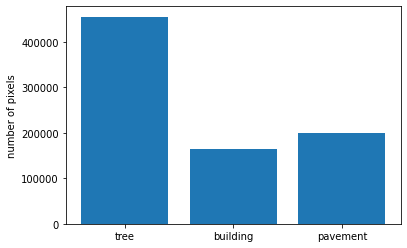

In [12]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

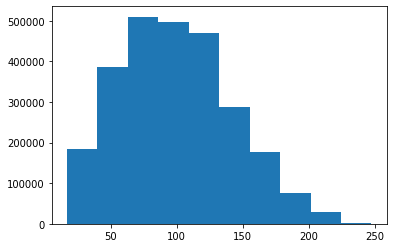

In [13]:
plt.hist(train_images.flatten())
plt.show()

In [14]:
Y = np.zeros(shape=(I, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [145]:
train_images.shape

(40, 256, 256)

In [146]:
train_sub = train_images[:20,:,:]

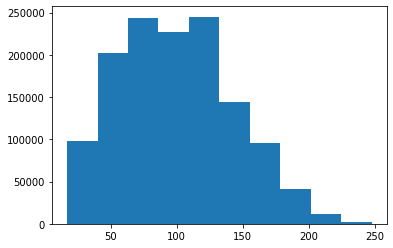

In [147]:
plt.hist(train_sub.flatten())
plt.show()

In [148]:
test_sub = train_images[20:,:,:] 

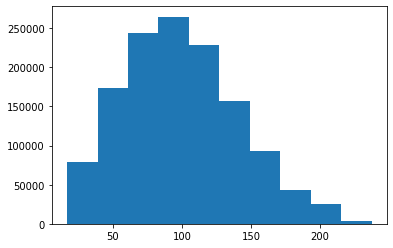

In [149]:
plt.hist(test_sub.flatten())
plt.show()

In [152]:
train_sub[19].shape

(256, 256)

In [153]:
X_train = train_sub.reshape(20,256,256,1)

In [154]:
X_train.shape

(20, 256, 256, 1)

In [155]:
X_test = test_sub.reshape(20,256,256,1)

In [208]:
Y_train = np.zeros(shape=(20, N, M,1), dtype=np.int8)
Y_train[:20, :, :,0] = tree_masks[:20,:,:]
#Y_train[:20, :, :, 1] = building_masks[:20,:,:]
#Y_train[:20, :, :, 2] = pavement_masks[:20,:,:]

In [209]:
Y_test = np.zeros(shape=(20, N, M,1), dtype=np.int8)
Y_test[:20, :, :,0] = tree_masks[20:,:,:] 
#Y_test[:20, :, :, 1] = building_masks[20:,:,:] 
#Y_test[:20, :, :, 2] = pavement_masks[20:,:,:] 

In [210]:
X_train.shape[1:]

(256, 256, 1)

In [232]:
X_test.shape

(20, 256, 256, 1)

In [233]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

#cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(1, activation='softmax'))

cnn1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [234]:
cnn1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 flatten_24 (Flatten)        (None, 516128)            0         
                                                                 
 dense_45 (Dense)            (None, 1)                 516129    
                                                                 
Total params: 516,449
Trainable params: 516,449
Non-trainable params: 0
_______________________________________________

In [235]:
#train the model
history1 = cnn1.fit(X_train, Y_train,
          batch_size=256,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [20,1] and labels shape [1310720]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py:5113)
]] [Op:__inference_train_function_8467]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py:5109)	
In[1] sparse_categorical_crossentropy/Reshape (defined at c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\runpy.py", line 192, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 563, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 1844, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\hkropp\AppData\Local\Temp/ipykernel_20468/1684607656.py", line 2, in <module>
>>>     history1 = cnn1.fit(X_train, Y_train,
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "c:\users\hkropp\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

In [212]:
X_train.shape

(20, 256, 256, 1)

In [213]:
X_test.shape

(20, 256, 256, 1)

In [214]:
Y_train.shape

(20, 256, 256, 1)

In [215]:
Y_test.shape

(20, 256, 256, 1)

20